In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

# Load in the data

In [2]:
train_df = pd.read_csv("../data/train.2024.04.16.csv")
test_df = pd.read_csv("../data/test.2024.04.16.csv")

# Selected Features
- F01: ML - MC
- F07: Phi,S
- F09: log10 [ P(4-6 Hz) / S(4-6 Hz) ]
- F10: log10 [ P(6-8 Hz) / S(6-8 Hz) ]
- F13: log10 [ S(2-4 Hz) / S(8-10 Hz) ]

In [3]:
 # Five selected features
feature_col_names = ['F01', 'F07', 'F09', 'F10', 'F13']

In [4]:
train_all_feats_df = train_df[~np.any(np.isnan(train_df[feature_col_names]), axis=1)]
test_feats_df = test_df[~np.any(np.isnan(test_df[feature_col_names]), axis=1)]

In [5]:
# Get all training examples that have values for the selected features

X_train = train_all_feats_df[feature_col_names].to_numpy()
y_train = train_all_feats_df["y"].to_numpy()

In [6]:
# Get all testing examples that have values for the selected features
X_test = test_feats_df[feature_col_names].to_numpy()
y_test = test_feats_df["y"].to_numpy()

In [21]:
keep_inds = np.sort(np.delete(np.arange(0, X_test.shape[0]), [105]))
X_test = X_test[keep_inds, :]
y_test = y_test[keep_inds]

In [7]:
# Get all testing examples that have values for all 13 features
feature_col_all = ['F01', 'F02', 'F03', 'F04',
       'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13']
test_all_feats_df = test_df[~np.any(np.isnan(test_df[feature_col_all]), axis=1)]
X_test_all = test_all_feats_df[feature_col_names].to_numpy()
y_test_all = test_all_feats_df["y"].to_numpy()

In [22]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))
print('Testing all feats class percentage:', np.unique(y_test_all, return_counts=True)[1]/len(y_test_all))

Training: (1358, 5) (1358,)
Testing: (325, 5) (325,)
Training class percentage: [0.17083947 0.7179676  0.11119293]
Testing class percentage: [0.16307692 0.72       0.11692308]
Testing all feats class percentage: [0.16908213 0.69565217 0.1352657 ]


In [9]:
np.unique(y_train, return_counts=True)[1]

array([232, 975, 151])

In [10]:
np.unique(y_test, return_counts=True)[1]

array([ 53, 235,  38])

In [11]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=36851234)
model = RandomForestClassifier(random_state=0)
params = {"n_estimators": [50, 100, 500, 100], "min_samples_leaf":[1, 2, 5, 10], "max_depth":[5, 10]}
gs = GridSearchCV(model, params, scoring="f1_macro", cv=rskf, n_jobs=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=36851234),
             estimator=RandomForestClassifier(random_state=0), n_jobs=5,
             param_grid={'max_depth': [5, 10],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'n_estimators': [50, 100, 500, 100]},
             scoring='f1_macro')

In [12]:
gs.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=500,
                       random_state=0)

In [13]:
gs.best_score_

0.9346017060326138

In [14]:
gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 500}

In [15]:
gs.cv_results_["mean_test_score"]

array([0.93065815, 0.92920636, 0.92979567, 0.92920636, 0.92795566,
       0.92976296, 0.93024258, 0.92976296, 0.92751756, 0.92935236,
       0.92657533, 0.92935236, 0.92192723, 0.92599196, 0.92597786,
       0.92599196, 0.92687316, 0.93066984, 0.93365133, 0.93066984,
       0.92919495, 0.9300204 , 0.93460171, 0.9300204 , 0.92975179,
       0.93107753, 0.93023643, 0.93107753, 0.92184577, 0.92554339,
       0.92390879, 0.92554339])

In [16]:
y_train_preds = gs.best_estimator_.predict(X_train)
f1_score(y_train, y_train_preds, average="macro")

0.9836134406552928

In [23]:
y_test_preds = gs.best_estimator_.predict(X_test)
f1_score(y_test, y_test_preds, average="macro")

0.9261424759233443

In [26]:
f1_score(y_test, y_test_preds, average="macro", labels=[0])

0.8990825688073395

In [27]:
f1_score(y_test, y_test_preds, average="macro", labels=[1])

0.9936305732484076

In [28]:
f1_score(y_test, y_test_preds, average="macro", labels=[2])

0.8857142857142857

In [24]:
cm = confusion_matrix(y_test, y_test_preds)
print(cm)

[[ 49   3   1]
 [  0 234   0]
 [  7   0  31]]


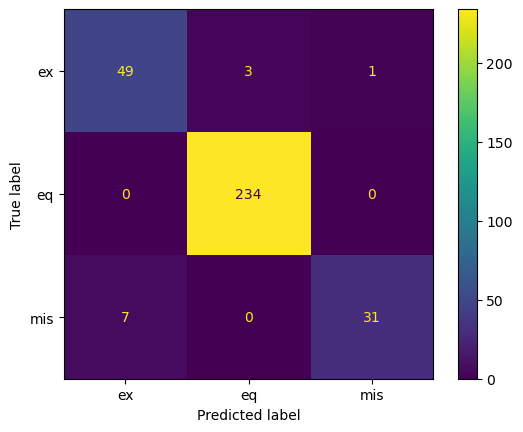

In [25]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=["ex", "eq", "mis"])
display.plot()